## Import Modules

In [11]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

## Load the Dataset

In [12]:
TRAIN_DIR = 'train'
TEST_DIR = 'test'

In [14]:
import os
import cv2
import numpy as np
import pandas as pd

# Function to load dataset
def load_dataset(directory):
    images = []
    labels = []
    
    # Loop over each label (subfolder) in the main directory
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)  # Correct path construction
        
        # Check if it is a directory
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                image_path = os.path.join(label_path, filename)
                # Read and preprocess the image (e.g., resize to 48x48 and convert to grayscale)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    image = cv2.resize(image, (48, 48))  # Resize to match your model input
                    images.append(image)
                    labels.append(label)  # Use the folder name as the label
                else:
                    print(f"Could not read image: {image_path}")
    
    return images, labels


train_images, train_labels = load_dataset(TRAIN_DIR)

train = pd.DataFrame({'image': train_images, 'label': train_labels})

train = train.sample(frac=1).reset_index(drop=True)

train.head()


,image,label
0,"[[167, 188, 245, 253, 138, 65, 54, 65, 69, 90,...",fear
1,"[[21, 19, 19, 28, 31, 28, 27, 27, 24, 20, 24, ...",neutral
2,"[[0, 1, 0, 0, 0, 1, 5, 4, 14, 92, 117, 127, 13...",angry
3,"[[105, 103, 135, 146, 141, 130, 102, 95, 149, ...",sad
4,"[[36, 33, 34, 54, 57, 43, 44, 45, 47, 47, 47, ...",happy


In [16]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

,image,label
0,"[[46, 34, 26, 23, 12, 32, 35, 26, 26, 38, 71, ...",angry
1,"[[55, 33, 54, 32, 26, 21, 50, 29, 38, 45, 79, ...",angry
2,"[[123, 123, 126, 131, 124, 69, 109, 149, 159, ...",angry
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",angry
4,"[[127, 121, 124, 137, 123, 118, 120, 111, 111,...",angry


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

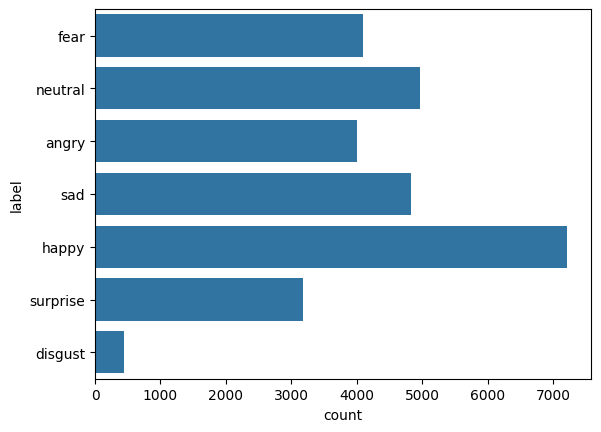

In [19]:
sns.countplot(train['label'])

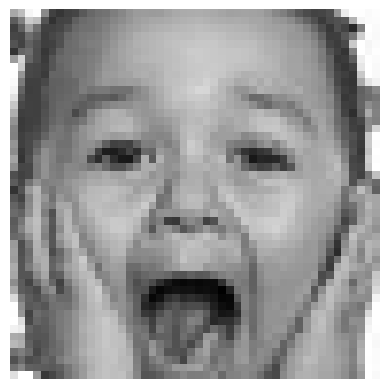

In [22]:
img = train['image'][0] 
plt.imshow(img, cmap='gray')  
plt.axis('off')  
plt.show()

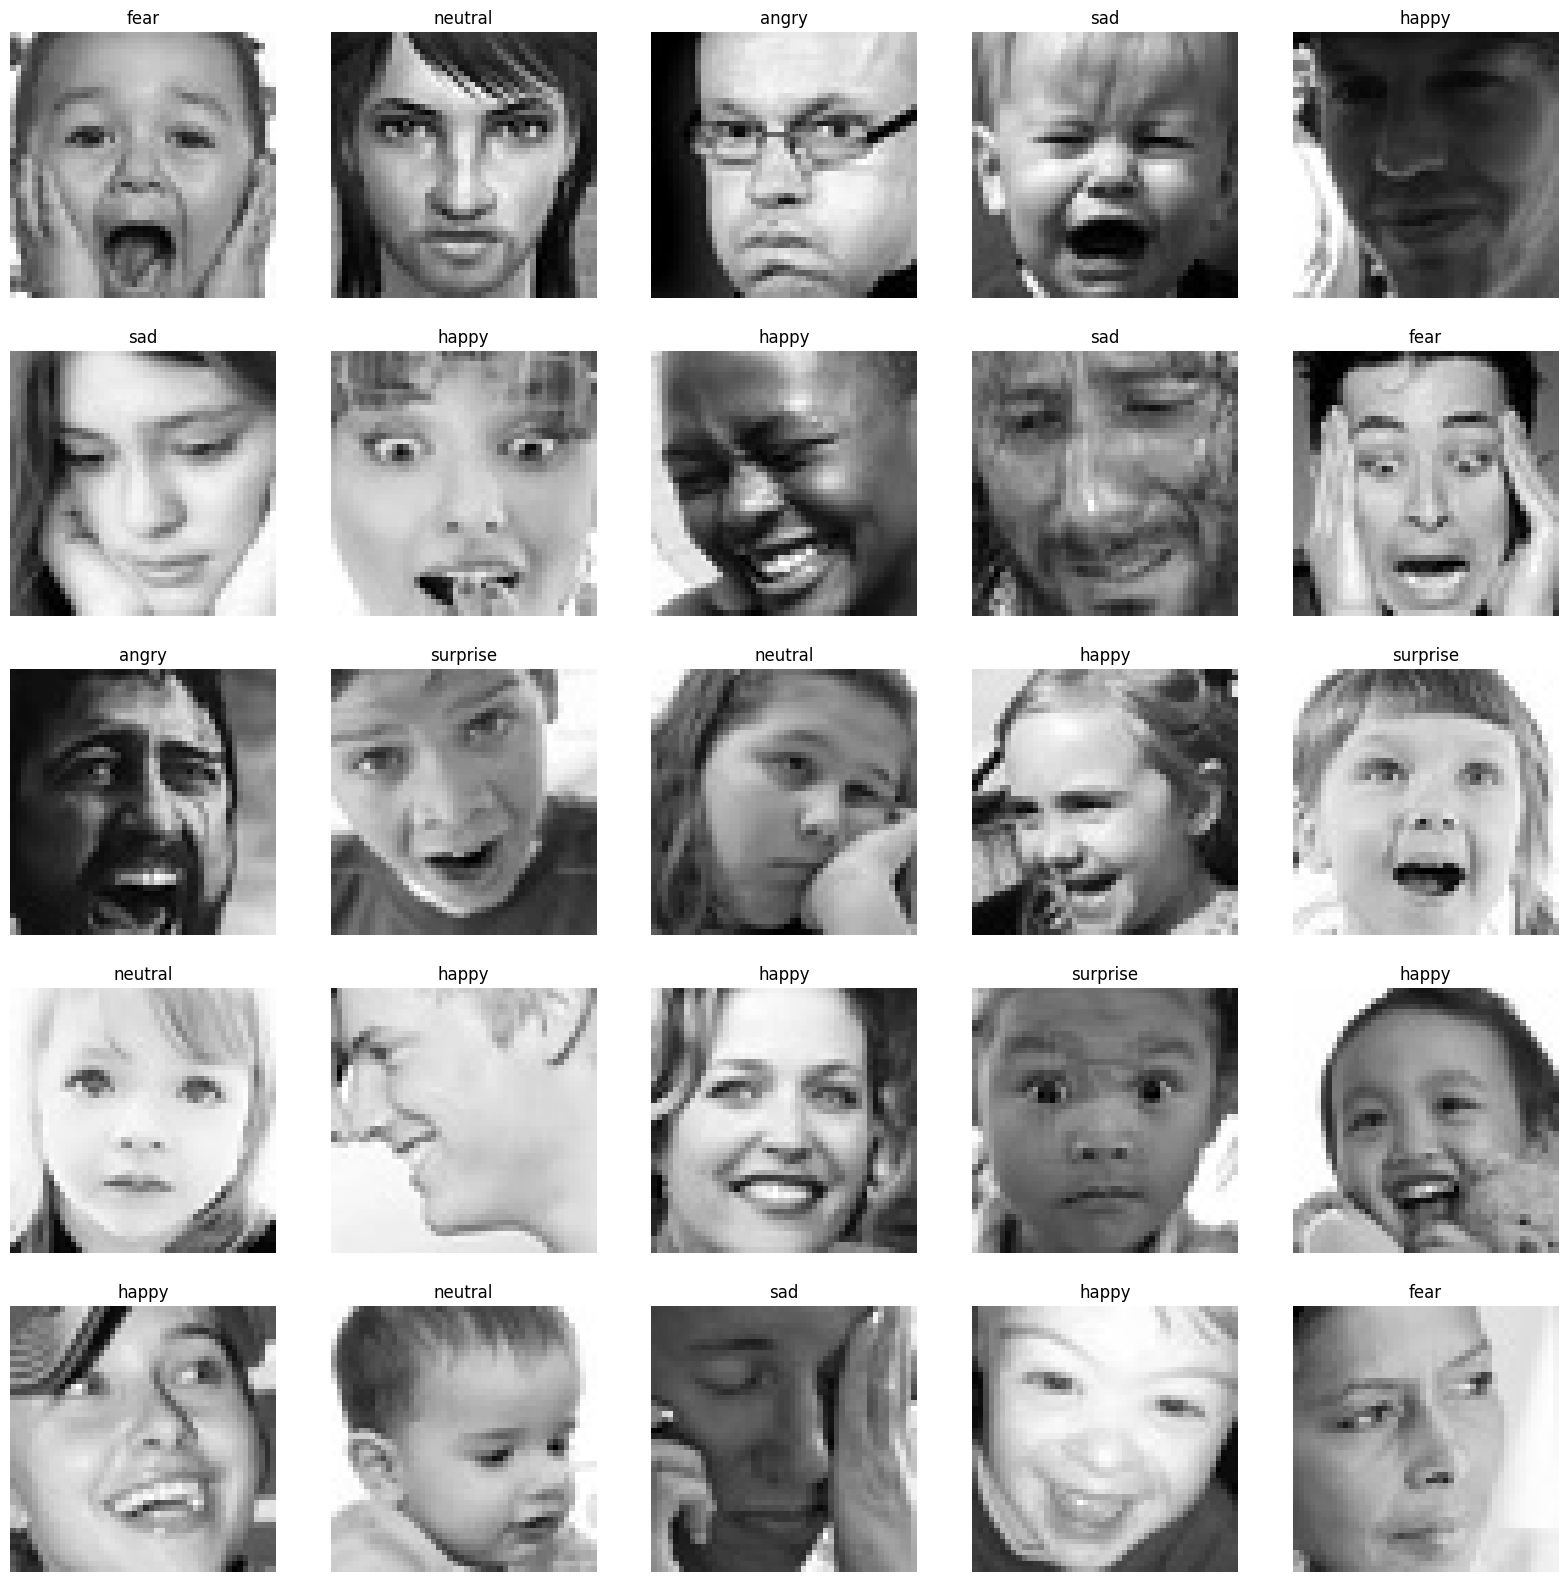

In [25]:

plt.figure(figsize=(20, 20))
files = train.iloc[0:25]  

for index, row in enumerate(files.itertuples(), 1):
    plt.subplot(5, 5, index)
    
    img = row.image 
    
    plt.imshow(img, cmap='gray')  
    plt.title(row.label)  
    plt.axis('off')  

plt.show()

## Feature Extraction

In [30]:
from tqdm import tqdm

In [32]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = image  
        img = np.array(img)  
        features.append(img)
    return np.array(features)

train_features = extract_features(train['image'])

100%|██████████| 28709/28709 [00:00<00:00, 363432.50it/s]


In [33]:
test_features = extract_features(test['image'])

100%|██████████| 7178/7178 [00:00<00:00, 257902.07it/s]


In [34]:

x_train = train_features/255.0
x_test = test_features/255.0

In [35]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [36]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [37]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.])

In [38]:

input_shape = (48, 48, 1)
output_class = 7

## Model Creation

In [41]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(output_class, activation='softmax'))



In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [49]:

history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 920ms/step - accuracy: 0.2595 - loss: 1.7751 - val_accuracy: 0.3164 - val_loss: 1.6726
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 205s 912ms/step - accuracy: 0.3226 - loss: 1.6882 - val_accuracy: 0.4058 - val_loss: 1.5132
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 158s 701ms/step - accuracy: 0.3946 - loss: 1.5438 - val_accuracy: 0.4446 - val_loss: 1.4036
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 168s 745ms/step - accuracy: 0.4328 - loss: 1.4727 - val_accuracy: 0.4890 - val_loss: 1.3301
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 172s 767ms/step - accuracy: 0.4488 - loss: 1.4280 - val_accuracy: 0.4979 - val_loss: 1.2867
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 171s 762ms/step - accuracy: 0.4709 - loss: 1.3773 - val_accuracy: 0.5146 - val_loss: 1.2515
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 163s 723ms/step - accuracy: 0.4848 - loss: 1.3434 - val_accuracy: 0.5261 - val_loss: 1.2297
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 163s 726ms/step - accuracy: 

## Plot the Results

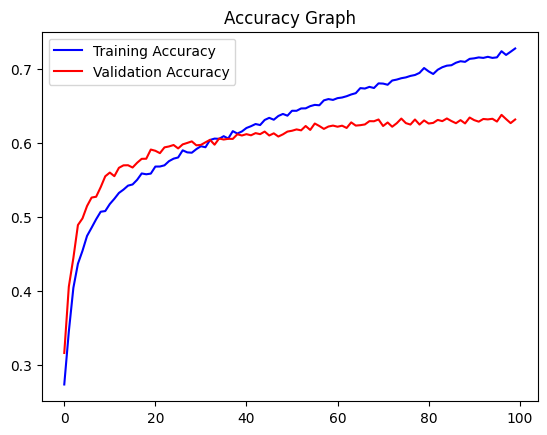

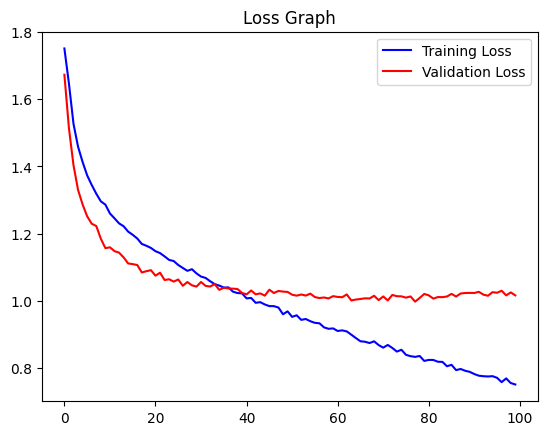

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted Output: happy


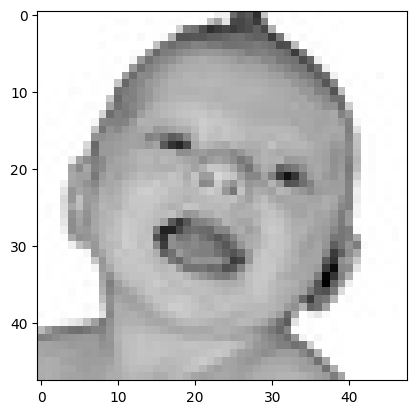

In [51]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted Output: happy


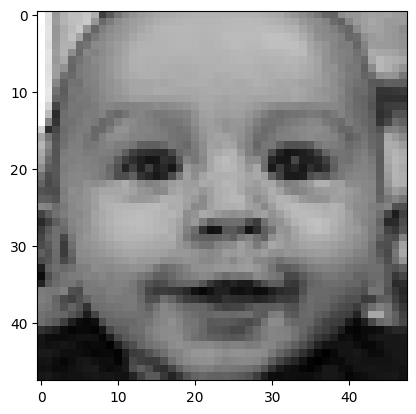

In [52]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicted Output: disgust


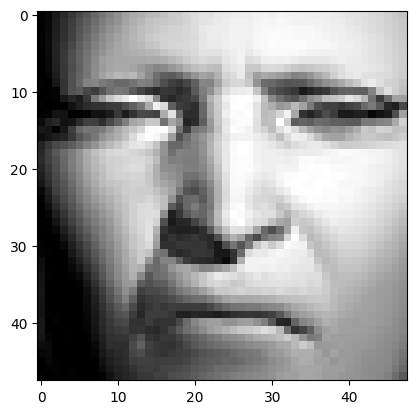

In [53]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [54]:
model.save('emotion_model.h5')